# Template - Strategy - Backtesting 

### Import Library

In [3]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [4]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [5]:
data = dataset.copy()

In [6]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [7]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [8]:
def cal_signal(r):
    signal = ''
    if r['Low'] < r['Low_s1'] - 0.1 and r['RSI'] > r['RSI_s1']:
        signal = 'long'
    elif r['High'] > r['High_s1'] + 0.1 and r['RSI'] < r['RSI_s1']:
        signal = 'short'
    return signal

def make_decision(r):
    decision = ''
    if r['Volume'] < r['vol_4_compare']:
        return decision
    if r['signal'] == 'long' and r['Close'] > r['Open']:
        decision = 'long'
    elif r['signal'] == 'short' and r['Close'] < r['Open']:
        decision = 'short'
    return decision

def prepare_data(df):
    df['Close_s1'] = df['Close'].shift(1)
    df['High_s1'] = df['High'].shift(1)
    df['Low_s1'] = df['Low'].shift(1)
    df["RSI"] = ta.rsi(df["Close"], length=14)
    df['RSI_s1'] = df['RSI'].shift(1)
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    df['signal'] = df['signal'].shift(1)
    df['vol_4_compare'] = df['Volume'].shift(2)
    df['decision'] = df.apply(lambda r: make_decision(r), axis=1)
    return df

In [9]:
prepared_data = prepare_data(data.copy())
prepared_data.dropna(inplace=True)

In [10]:
class MainStrategy01(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        decision = self.data.decision[-1]
        close_price = self.data.Close[-1]
        high_price = self.data.High[-2]
        low_price = self.data.Low[-2]
        if decision == 'long':
            buy_price = close_price
            sl = low_price - 0.1
            tp = buy_price + self.reward_on_risk * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif decision == 'short':
            sell_price = close_price
            sl = high_price + 0.1
            tp = sell_price - self.reward_on_risk * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

In [11]:
bt = Backtest(prepared_data, MainStrategy01, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [12]:
stats

Start                     2020-11-02 10:15:00
End                       2025-02-13 14:45:00
Duration                   1564 days 04:30:00
Exposure Time [%]                   36.127242
Equity Final [$]                   1849.38138
Equity Peak [$]                    1954.92619
Return [%]                          23.292092
Buy & Hold Return [%]               48.413227
Return (Ann.) [%]                    5.128698
Volatility (Ann.) [%]                7.822958
Sharpe Ratio                         0.655596
Sortino Ratio                        1.195241
Calmar Ratio                         0.348157
Max. Drawdown [%]                  -14.730985
Avg. Drawdown [%]                   -0.687278
Max. Drawdown Duration      350 days 03:50:00
Avg. Drawdown Duration       10 days 12:39:00
# Trades                                 1787
Win Rate [%]                        35.478456
Best Trade [%]                       3.097546
Worst Trade [%]                     -2.463465
Avg. Trade [%]                    

In [13]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,20,26,896.63093,900.5,-3.86907,-0.004315,2020-11-02 13:20:00,2020-11-02 13:50:00,None,0 days 00:30:00
1,-1,53,53,907.12778,908.5,-1.37222,-0.001513,2020-11-03 10:25:00,2020-11-03 10:25:00,None,0 days 00:00:00
2,-1,114,129,912.92604,914.7,-1.77396,-0.001943,2020-11-04 11:15:00,2020-11-04 13:55:00,None,0 days 02:40:00
3,1,131,134,917.07504,912.4,-4.67504,-0.005098,2020-11-04 14:05:00,2020-11-04 14:20:00,None,0 days 00:15:00
4,-1,181,187,915.22535,910.0,5.22535,0.005709,2020-11-05 14:00:00,2020-11-05 14:30:00,None,0 days 00:30:00
...,...,...,...,...,...,...,...,...,...,...,...
1782,1,54300,54309,1332.79972,1329.5,-3.29972,-0.002476,2025-02-11 13:30:00,2025-02-11 14:15:00,None,0 days 00:45:00
1783,1,54311,54312,1331.79942,1332.4,0.60058,0.000451,2025-02-11 14:25:00,2025-02-11 14:30:00,None,0 days 00:05:00
1784,1,54336,54339,1340.10191,1339.1,-1.00191,-0.000748,2025-02-12 10:50:00,2025-02-12 11:05:00,None,0 days 00:15:00
1785,-1,54369,54389,1329.30109,1331.8,-2.49891,-0.001880,2025-02-13 09:20:00,2025-02-13 11:00:00,None,0 days 01:40:00


In [14]:
# bt.plot()

In [15]:
stats['_trades'].tail(15)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1772,1,53837,53845,1324.69729,1322.1,-2.59729,-0.001961,2025-01-22 13:10:00,2025-01-22 13:50:00,None,0 days 00:40:00
1773,1,53885,53900,1338.50143,1344.8,6.29857,0.004706,2025-01-23 11:30:00,2025-01-23 14:10:00,None,0 days 02:40:00
1774,1,53919,53919,1341.80242,1340.4,-1.40242,-0.001045,2025-01-24 10:05:00,2025-01-24 10:05:00,None,0 days 00:00:00
1775,1,53927,53944,1340.60206,1344.7,4.09794,0.003057,2025-01-24 10:45:00,2025-01-24 13:35:00,None,0 days 02:50:00
1776,-1,53948,53955,1343.49683,1342.1,1.39683,0.001040,2025-01-24 13:55:00,2025-01-24 14:30:00,None,0 days 00:35:00
1777,1,53980,53998,1322.09651,1317.3,-4.79651,-0.003628,2025-02-03 10:55:00,2025-02-03 13:50:00,None,0 days 02:55:00
1778,-1,53999,54006,1317.00478,1315.7,1.30478,0.000991,2025-02-03 13:55:00,2025-02-03 14:30:00,None,0 days 00:35:00
1779,1,54038,54057,1327.29807,1328.5,1.20193,0.000906,2025-02-04 11:30:00,2025-02-04 14:30:00,None,0 days 03:00:00
1780,1,54174,54210,1339.60176,1343.3,3.69824,0.002761,2025-02-07 10:05:00,2025-02-07 14:30:00,None,0 days 04:25:00
1781,1,54245,54253,1334.00008,1332.3,-1.70008,-0.001274,2025-02-10 13:10:00,2025-02-10 13:50:00,None,0 days 00:40:00


In [16]:
prepared_data[prepared_data.decision != ''].tail(30)

,Open,High,Low,Close,Volume,Close_s1,High_s1,Low_s1,RSI,RSI_s1,signal,vol_4_compare,decision
Date,,,,,,,,,,,,,
2025-01-21 10:25:00,1328.8,1328.8,1327.0,1327.0,7259,1328.8,1329.8,1328.6,45.379495,54.141884,short,1476.0,short
2025-01-22 09:50:00,1322.8,1323.5,1322.5,1322.6,2449,1322.9,1324.7,1322.3,45.637496,46.809616,short,2071.0,short
2025-01-22 11:25:00,1322.8,1323.5,1322.4,1322.5,1879,1322.6,1323.7,1321.9,45.803431,46.204321,short,1739.0,short
2025-01-22 13:05:00,1323.3,1325.1,1323.3,1324.3,4181,1323.2,1323.3,1322.2,54.442957,49.369747,long,60.0,long
2025-01-23 11:25:00,1336.8,1338.2,1336.1,1338.2,5182,1336.9,1337.3,1336.1,75.176802,72.320798,long,2814.0,long
2025-01-23 13:05:00,1337.7,1337.9,1337.2,1337.6,1560,1337.7,1339.0,1337.5,70.444554,71.090244,short,19.0,short
2025-01-23 13:50:00,1341.1,1342.3,1340.0,1340.4,5365,1341.1,1341.9,1339.4,65.776718,69.413539,short,5119.0,short
2025-01-23 14:25:00,1345.0,1345.0,1342.6,1342.9,10337,1344.9,1347.7,1344.9,60.387764,68.398303,short,8648.0,short
2025-01-24 10:00:00,1341.0,1341.8,1340.5,1341.4,1632,1341.3,1341.7,1340.5,53.809353,53.457050,long,1131.0,long


In [17]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [18]:
## Strategy 02

In [19]:
# Define signal calculation with RSI trend confirmation
def cal_signal2(r):
    signal = ''
    if r['Low'] < r['Low_s1'] - 0.1 and r['RSI'] > r['RSI_s1'] and r['RSI'] > 50:
        signal = 'long'
    elif r['High'] > r['High_s1'] + 0.1 and r['RSI'] < r['RSI_s1'] and r['RSI'] < 50:
        signal = 'short'
    return signal

# Define decision-making with volume and trend filter
def make_decision2(r):
    decision = ''
    if r['Volume'] < r['vol_sma_5']:  # Stronger volume confirmation
        return decision
    if r['signal'] == 'long' and r['Close'] > r['Open'] and r['Close'] > r['EMA_20']:
        decision = 'long'
    elif r['signal'] == 'short' and r['Close'] < r['Open'] and r['Close'] < r['EMA_20']:
        decision = 'short'
    return decision
    
def prepare2_data(df):
    df['Close_s1'] = df['Close'].shift(1)
    df['High_s1'] = df['High'].shift(1)
    df['Low_s1'] = df['Low'].shift(1)
    df['RSI'] = ta.rsi(df['Close'], length=14)
    df['RSI_s1'] = df['RSI'].shift(1)
    df['EMA_20'] = ta.ema(df['Close'], length=20)
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=5)
    df['vol_sma_5'] = df['Volume'].rolling(5).mean()
    df['signal'] = df.apply(cal_signal2, axis=1)
    df['signal'] = df['signal'].shift(1)
    df['decision'] = df.apply(make_decision2, axis=1)
    return df

data2 = prepare2_data(data.copy())
data2.dropna(inplace=True)

# Implement strategy with ATR-based SL/TP
class Main2Strategy(Strategy):
    reward_on_risk = 3
    
    def init(self):
        self._broker._cash = 1500
        super().init()
    
    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return
        
        if self.position:
            return 
        
        decision = self.data.decision[-1]
        close_price = self.data.Close[-1]
        high_price = self.data.High[-2]
        low_price = self.data.Low[-2]
        atr = self.data.ATR[-1]
        
        if decision == 'long':
            buy_price = close_price
            sl = low_price - 0.1
            tp = buy_price + self.reward_on_risk * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif decision == 'short':
            sell_price = close_price
            sl = high_price + 0.1
            tp = sell_price - self.reward_on_risk * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

bt2 = Backtest(data2, Main2Strategy, commission=.0003, exclusive_orders=True)
stats2 = bt2.run()
stats2

Start                     2020-11-02 10:35:00
End                       2025-02-13 14:45:00
Duration                   1564 days 04:10:00
Exposure Time [%]                   20.894288
Equity Final [$]                   1536.37191
Equity Peak [$]                    1698.32202
Return [%]                           2.424794
Buy & Hold Return [%]               48.710251
Return (Ann.) [%]                    0.566917
Volatility (Ann.) [%]                6.585852
Sharpe Ratio                         0.086081
Sortino Ratio                         0.14344
Calmar Ratio                         0.048216
Max. Drawdown [%]                  -11.757822
Avg. Drawdown [%]                   -0.950882
Max. Drawdown Duration     1345 days 04:50:00
Avg. Drawdown Duration       38 days 20:03:00
# Trades                                 1086
Win Rate [%]                        35.451197
Best Trade [%]                       3.827652
Worst Trade [%]                     -2.463465
Avg. Trade [%]                    

In [20]:
data2

,Open,High,Low,Close,Volume,Close_s1,High_s1,Low_s1,RSI,RSI_s1,EMA_20,ATR,vol_sma_5,signal,decision
Date,,,,,,,,,,,,,,,
2020-11-02 10:35:00,899.6,900.4,899.1,899.4,1106,900.0,900.1,899.3,48.103661,51.908107,899.425000,1.352948,1654.8,,
2020-11-02 10:40:00,899.2,899.4,898.8,899.4,1652,899.4,900.4,899.1,48.103661,48.103661,899.422619,1.200602,1524.2,short,
2020-11-02 10:45:00,899.4,900.2,896.7,897.9,3197,899.4,899.4,898.8,39.673015,48.103661,899.277608,1.664762,1804.4,,
2020-11-02 10:50:00,897.8,898.9,896.8,898.3,2997,897.9,900.2,896.7,42.563838,39.673015,899.184502,1.752457,2020.4,short,
2020-11-02 10:55:00,898.0,898.3,897.2,897.3,1668,898.3,898.9,896.8,37.700031,42.563838,899.005026,1.621191,2124.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583,1333.8,1335.2,1333.7,52.893441,47.045756,1334.824575,1.595744,4600.8,,
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753,1335.0,1335.4,1333.4,52.374395,52.893441,1334.831758,1.636595,5036.4,long,
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879,1334.9,1336.5,1334.7,60.338107,52.374395,1335.019210,1.689276,5339.0,,


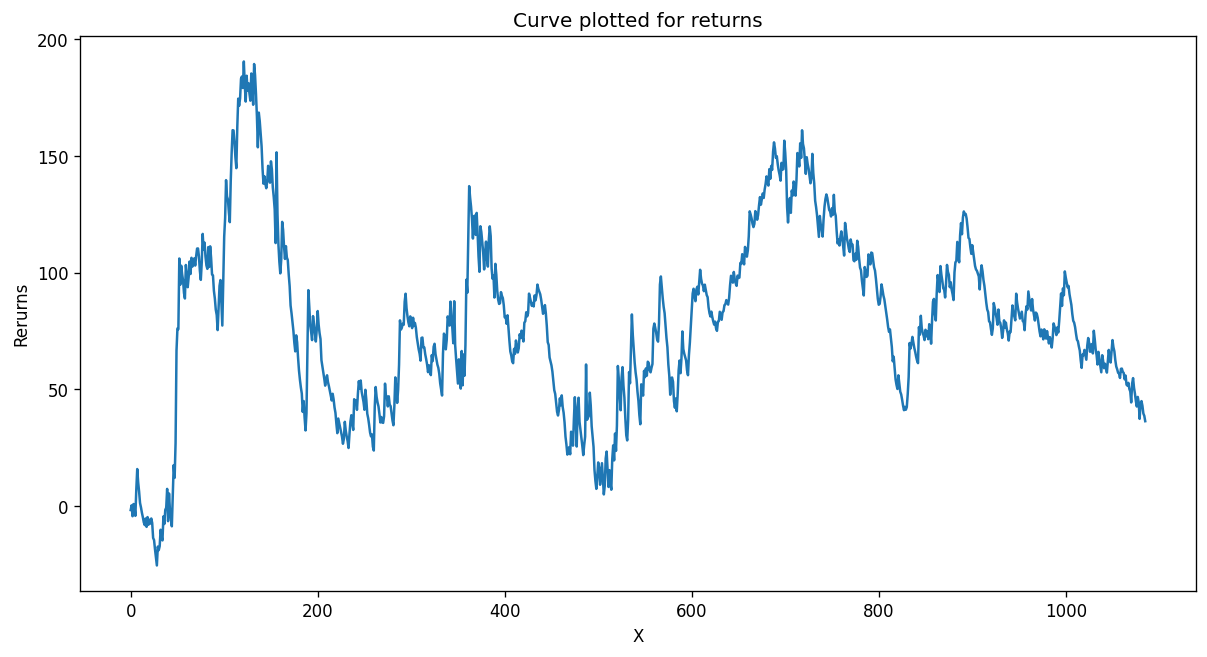

In [21]:
trades = stats2['_trades']
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Strategy 03

In [22]:
def cal_signal3(r):
    # Continuous strategy: pull back a litle before continue the long trend
    signal = ''
    if r['Low'] < r['Low_s1'] and r['RSI'] > r['RSI_s1'] and r['EMA_5'] > r['EMA_5s1']:
        signal = 'long'
    elif r['High'] > r['High_s1'] and r['RSI'] < r['RSI_s1'] and r['EMA_5'] < r['EMA_5s1']:
        signal = 'short'
    return signal

def make_decision3(r):
    return r['signal']
    
def prepare_data3(df):
    df['Close_s1'] = df['Close'].shift(1)
    df['High_s1'] = df['High'].shift(1)
    df['Low_s1'] = df['Low'].shift(1)
    df['RSI'] = ta.rsi(df['Close'], length=14)
    df['RSI_s1'] = df['RSI'].shift(1)
    df['EMA_5'] = ta.ema(df['Close'], length=5)
    df['EMA_5s1'] = df['EMA_5'].shift(1)
    df['signal'] = df.apply(cal_signal3, axis=1)
    df['decision'] = df.apply(make_decision3, axis=1)
    return df

data3 = prepare_data3(data.copy())
data3.dropna(inplace=True)

# Implement strategy with ATR-based SL/TP
class MainStrategy3(Strategy):
    reward_on_risk = 3
    
    def init(self):
        self._broker._cash = 1500
        super().init()
    
    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return
        
        if self.position:
            return 
        
        decision = self.data.decision[-1]
        close_price = self.data.Close[-1]
        high_price = self.data.High[-1]
        low_price = self.data.Low[-1]
        
        if decision == 'long':
            buy_price = close_price
            sl = low_price - 0.1
            tp = buy_price + self.reward_on_risk * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif decision == 'short':
            sell_price = close_price
            sl = high_price + 0.1
            tp = sell_price - self.reward_on_risk * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

bt3 = Backtest(data3, MainStrategy3, commission=.0003, exclusive_orders=True)
stats3 = bt3.run()
stats3

Start                     2020-11-02 10:15:00
End                       2025-02-13 14:45:00
Duration                   1564 days 04:30:00
Exposure Time [%]                   43.691194
Equity Final [$]                   1892.09651
Equity Peak [$]                    2145.00331
Return [%]                          26.139767
Buy & Hold Return [%]               48.413227
Return (Ann.) [%]                    5.460826
Volatility (Ann.) [%]                7.995625
Sharpe Ratio                         0.682977
Sortino Ratio                        1.226244
Calmar Ratio                         0.434529
Max. Drawdown [%]                   -12.56724
Avg. Drawdown [%]                   -0.537316
Max. Drawdown Duration      717 days 00:40:00
Avg. Drawdown Duration        7 days 07:39:00
# Trades                                 3774
Win Rate [%]                        34.048755
Best Trade [%]                       3.804895
Worst Trade [%]                     -2.270303
Avg. Trade [%]                    

In [23]:
stats3['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,5,9,898.93024,896.1,2.83024,0.003148,2020-11-02 10:40:00,2020-11-02 11:00:00,None,0 days 00:20:00
1,1,13,33,898.26940,905.8,7.53060,0.008383,2020-11-02 11:20:00,2020-11-02 14:25:00,None,0 days 03:05:00
2,1,43,52,908.27240,907.4,-0.87240,-0.000961,2020-11-03 09:35:00,2020-11-03 10:20:00,None,0 days 00:45:00
3,1,59,64,909.27270,907.9,-1.37270,-0.001510,2020-11-03 10:55:00,2020-11-03 11:20:00,None,0 days 00:25:00
4,-1,68,77,907.12778,903.8,3.32778,0.003668,2020-11-03 13:05:00,2020-11-03 13:50:00,None,0 days 00:45:00
...,...,...,...,...,...,...,...,...,...,...,...
3769,-1,54334,54335,1338.99818,1339.9,-0.90182,-0.000674,2025-02-12 10:40:00,2025-02-12 10:45:00,None,0 days 00:05:00
3770,-1,54350,54350,1338.49833,1339.2,-0.70167,-0.000524,2025-02-12 13:25:00,2025-02-12 13:25:00,None,0 days 00:00:00
3771,-1,54354,54355,1338.89821,1337.5,1.39821,0.001044,2025-02-12 13:45:00,2025-02-12 13:50:00,None,0 days 00:05:00
3772,-1,54368,54379,1330.40076,1327.8,2.60076,0.001955,2025-02-13 09:15:00,2025-02-13 10:10:00,None,0 days 00:55:00


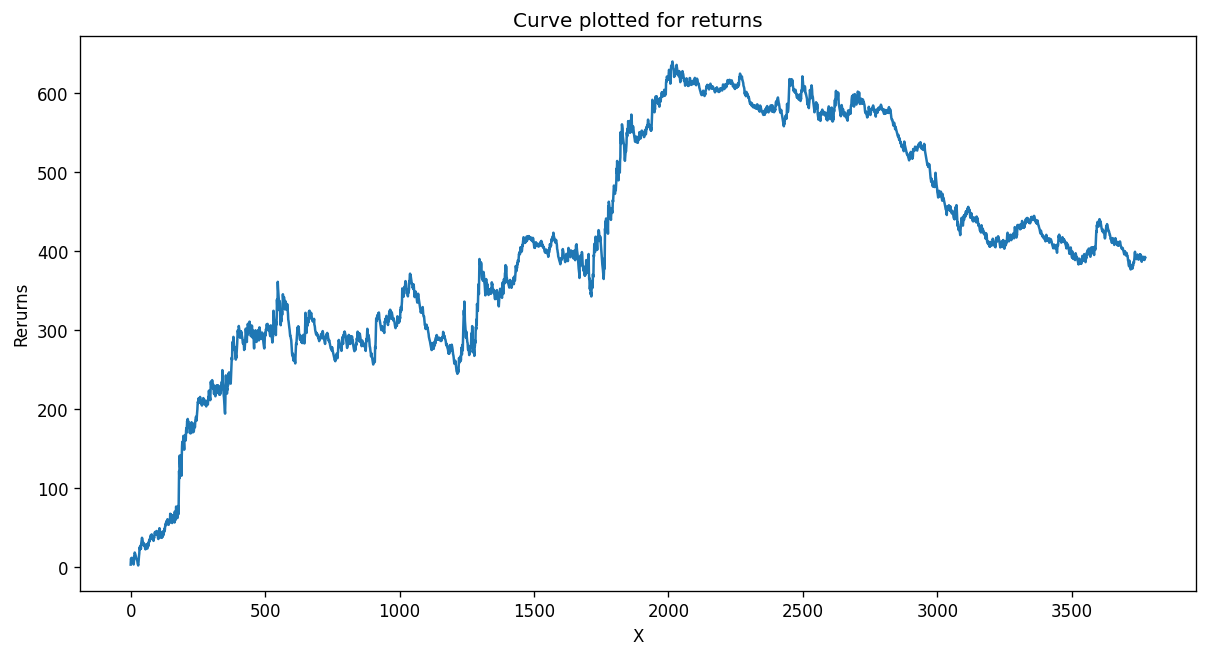

In [24]:
trades = stats3['_trades']
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Strategy V4 

In [35]:
def cal_signalv4(r):
    # Reversal strategy:
    signal = ''
    if r['Low'] < r['Low_s1'] and r['RSI'] > r['RSI_s1'] and r['lower_shadow'] > 1.1:
        signal = 'long'
    elif r['High'] > r['High_s1'] and r['RSI'] < r['RSI_s1'] and r['upper_wick'] > 1.1:
        signal = 'short'
    return signal

def make_decisionv4(r):
    return r['signal']
    
def prepare_datav4(df):
    df['Close_s1'] = df['Close'].shift(1)
    df['High_s1'] = df['High'].shift(1)
    df['Low_s1'] = df['Low'].shift(1)
    df['RSI'] = ta.rsi(df['Close'], length=14)
    df['RSI_s1'] = df['RSI'].shift(1)
    df['EMA_5'] = ta.ema(df['Close'], length=5)
    df['EMA_5s1'] = df['EMA_5'].shift(1)
    df["body_size"] = abs(df["Close"] - df["Open"])
    df['upper_wick'] = df.apply(lambda r: r['High'] - max(r['Close'], r['Open']), axis=1)
    df['lower_shadow'] = df.apply(lambda r: min(r['Close'], r['Open']) - r['Low'], axis=1)
    df['signal'] = df.apply(cal_signalv4, axis=1)
    df['decision'] = df.apply(make_decisionv4, axis=1)
    return df

data_v4 = prepare_datav4(data.copy())
data_v4.dropna(inplace=True)

class MainStrategyV4(Strategy):
    reward_on_risk = 3
    
    def init(self):
        self._broker._cash = 3500
        super().init()
    
    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return
        
        if self.position:
            return 
        
        decision = self.data.decision[-1]
        close_price = self.data.Close[-1]
        high_price = self.data.High[-1]
        low_price = self.data.Low[-1]
        
        if decision == 'long':
            buy_price = close_price
            sl = low_price - 0.1
            tp = buy_price + self.reward_on_risk * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif decision == 'short':
            sell_price = close_price
            sl = high_price + 0.1
            tp = sell_price - self.reward_on_risk * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

btv4 = Backtest(data_v4, MainStrategyV4, commission=.0003, exclusive_orders=True)
stats_v4 = btv4.run()
stats_v4

Start                     2020-11-02 10:15:00
End                       2025-02-13 14:45:00
Duration                   1564 days 04:30:00
Exposure Time [%]                   23.290944
Equity Final [$]                   2867.71016
Equity Peak [$]                    3549.99465
Return [%]                         -18.065424
Buy & Hold Return [%]               48.413227
Return (Ann.) [%]                   -4.583767
Volatility (Ann.) [%]                3.400199
Sharpe Ratio                        -1.348088
Sortino Ratio                       -1.821472
Calmar Ratio                        -0.233705
Max. Drawdown [%]                  -19.613517
Avg. Drawdown [%]                   -1.567894
Max. Drawdown Duration     1312 days 01:45:00
Avg. Drawdown Duration       91 days 15:49:00
# Trades                                 1965
Win Rate [%]                        30.636132
Best Trade [%]                       3.628362
Worst Trade [%]                     -2.270303
Avg. Trade [%]                    

In [34]:
stats_v4['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,19,26,899.13018,900.5,-1.36982,-0.001523,2020-11-02 13:15:00,2020-11-02 13:50:00,None,0 days 00:35:00
1,1,66,68,908.47246,906.5,-1.97246,-0.002171,2020-11-03 11:30:00,2020-11-03 13:05:00,None,0 days 01:35:00
2,1,69,69,907.77225,906.2,-1.57225,-0.001732,2020-11-03 13:10:00,2020-11-03 13:10:00,None,0 days 00:00:00
3,1,176,182,916.57489,914.3,-2.27489,-0.002482,2020-11-05 13:35:00,2020-11-05 14:05:00,None,0 days 00:30:00
4,-1,236,238,910.42679,910.5,-0.07321,-0.000080,2020-11-06 14:20:00,2020-11-06 14:30:00,None,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...
2447,1,54152,54159,1341.20224,1339.4,-1.80224,-0.001344,2025-02-06 13:55:00,2025-02-06 14:30:00,None,0 days 00:35:00
2448,1,54222,54226,1327.89825,1330.8,2.90175,0.002185,2025-02-10 09:50:00,2025-02-10 10:10:00,None,0 days 00:20:00
2449,-1,54276,54279,1328.20142,1330.1,-1.89858,-0.001429,2025-02-11 10:05:00,2025-02-11 10:20:00,None,0 days 00:15:00
2450,1,54370,54379,1330.69909,1328.4,-2.29909,-0.001728,2025-02-13 09:25:00,2025-02-13 10:10:00,None,0 days 00:45:00


In [32]:
data_v4[data_v4.signal != '']

,Open,High,Low,Close,Volume,Close_s1,High_s1,Low_s1,RSI,RSI_s1,EMA_5,EMA_5s1,body_size,upper_wick,lower_shadow,signal,decision
Date,,,,,,,,,,,,,,,,,
2020-11-02 13:10:00,899.2,900.4,898.9,899.3,1911,899.4,899.7,898.0,53.643453,54.299481,898.804553,898.556829,0.1,1.1,0.3,short,short
2020-11-02 13:25:00,897.4,898.5,896.4,896.7,2420,897.4,897.5,896.4,40.760317,43.874948,897.508756,897.913135,0.7,1.1,0.3,short,short
2020-11-03 11:25:00,908.1,908.2,906.6,908.0,4298,907.9,908.9,907.6,51.515417,50.969360,908.485460,908.728190,0.1,0.1,1.4,long,long
2020-11-03 13:05:00,907.4,907.9,906.3,907.5,2081,907.4,908.5,907.0,48.475369,47.810214,907.843840,908.015760,0.1,0.4,1.1,long,long
2020-11-05 13:30:00,916.2,916.7,914.4,916.5,5062,916.3,916.8,916.0,47.529730,46.116564,916.800843,916.951264,0.3,0.2,1.8,long,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-06 13:50:00,1339.6,1340.8,1338.4,1340.5,3317,1339.6,1339.9,1339.1,51.924359,46.358764,1339.684658,1339.276987,0.9,0.3,1.2,long,long
2025-02-10 09:45:00,1327.2,1327.8,1325.2,1327.5,7722,1327.0,1332.0,1326.3,24.126864,22.022385,1329.692194,1330.788292,0.3,0.3,2.0,long,long
2025-02-11 10:00:00,1328.8,1330.0,1328.4,1328.7,3072,1328.8,1329.4,1328.1,37.703976,38.003243,1329.263332,1329.544998,0.1,1.2,0.3,short,short
